In [1]:
%matplotlib notebook

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astroquery.jplhorizons import Horizons
import datetime
from matplotlib.dates import DateFormatter
from astropy.io import fits
from astropy import visualization as aviz
from astropy import units as u
from astropy.visualization.wcsaxes import WCSAxes
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import os
from astropy.time import Time
from reproject.mosaicking import find_optimal_celestial_wcs
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd

# Define the target name to search Horizons

In [4]:
# the Horizons query may fail if an object has multiple identifiers, select one from the error message and run query again
object_id = "Didymos"
JPL_id = "920065803"

# Set location and times

In [5]:
# ephem settings
loc = {"lon":36.2619616666667,"lat":4.283555,"elevation":0.384} # TBI shack
times = {'start':'2022-09-26 12:00', 'stop':'2022-09-27 12:00', # dates to query
                       'step':'10min'}
low_shutter = 20.0 # degrees
lowest_lim = 10.0 # degrees

# Query Horizons
https://ssd.jpl.nasa.gov/horizons/manual.html

In [6]:
# query ephemerides from Horizons
print("{} query Horizons".format(object_id))
obj = Horizons(id=JPL_id, location = loc, epochs = times)
eph = obj.ephemerides()
df_eph = eph.to_pandas()

Didymos query Horizons


In [7]:
df_eph.columns

Index(['targetname', 'datetime_str', 'datetime_jd', 'solar_presence', 'flags',
       'RA', 'DEC', 'RA_app', 'DEC_app', 'RA_rate', 'DEC_rate', 'AZ', 'EL',
       'AZ_rate', 'EL_rate', 'sat_X', 'sat_Y', 'sat_PANG', 'siderealtime',
       'airmass', 'magextinct', 'V', 'surfbright', 'illumination',
       'illum_defect', 'sat_sep', 'sat_vis', 'ang_width', 'PDObsLon',
       'PDObsLat', 'PDSunLon', 'PDSunLat', 'SubSol_ang', 'SubSol_dist',
       'NPole_ang', 'NPole_dist', 'EclLon', 'EclLat', 'r', 'r_rate', 'delta',
       'delta_rate', 'lighttime', 'vel_sun', 'vel_obs', 'elong', 'elongFlag',
       'alpha', 'lunar_elong', 'lunar_illum', 'sat_alpha', 'sunTargetPA',
       'velocityPA', 'OrbPlaneAng', 'constellation', 'TDB-UT', 'ObsEclLon',
       'ObsEclLat', 'NPole_RA', 'NPole_DEC', 'GlxLon', 'GlxLat', 'solartime',
       'earth_lighttime', 'RA_3sigma', 'DEC_3sigma', 'SMAA_3sigma',
       'SMIA_3sigma', 'Theta_3sigma', 'Area_3sigma', 'RSS_3sigma', 'r_3sigma',
       'r_rate_3sigma', 'SBand

In [8]:
# select times when it is not daylight and the objects are above the horizon
df_eph_night = df_eph[(df_eph["solar_presence"]!="*") & (df_eph["EL"]>0)]

In [9]:
# print off either the asteroidal or cometary brightness and rate of motion
try:
    print(df_eph[["V","RA_rate","DEC_rate"]])
except:
    print(df_eph[["Tmag","Nmag","RA_rate","DEC_rate"]])

        V   RA_rate   DEC_rate
0    <NA>  400.2504   88.53196
1    <NA>  400.4582   87.92394
2    <NA>  400.6098   87.31286
3    <NA>  400.7051   86.70006
4    <NA>  400.7439   86.08690
..    ...       ...        ...
140  <NA>  404.9490  106.70650
141  <NA>  405.4154  106.13300
142  <NA>  405.8272  105.55020
143  <NA>  406.1838  104.95940
144  <NA>  406.4844  104.36190

[145 rows x 3 columns]


# Make the visibility plot

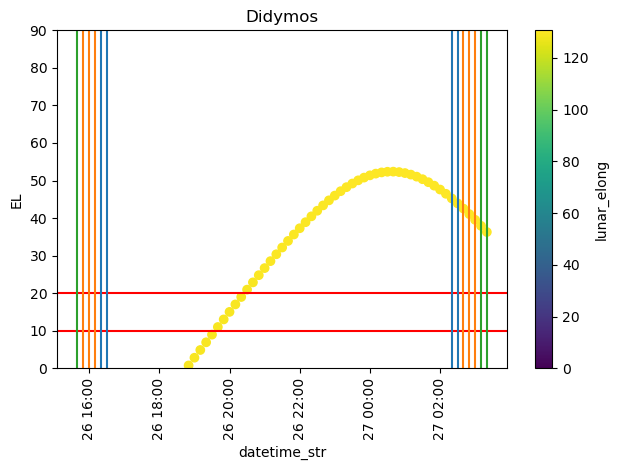

In [10]:
x_plot = "datetime_str"
y_plot = "EL"
c_plot = "lunar_elong"

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

# convert astropy Time into python datetime to make plotting with timestamps a bit easier
x_dates = [datetime.datetime.strptime(d,'%Y-%b-%d %H:%M') for d in df_eph_night[x_plot]]

# plot the object with colour bar (note that vmin=0 ensures colour scheme always starts in the same place)
s1=ax1.scatter(x_dates,df_eph_night[y_plot],c=df_eph_night[c_plot], label = object_id, vmin=0)
cbar1 = fig.colorbar(s1)

# plot telescope elevation limits
ax1.axhline(low_shutter,c="r")
ax1.axhline(lowest_lim,c="r")

# plot all astronomical, nautical and civil twilight times
for i,x in enumerate(["A","N","C"]):
    for d in df_eph[df_eph["solar_presence"]==x][x_plot]:
        ax1.axvline(datetime.datetime.strptime(d,'%Y-%b-%d %H:%M'),c="C{}".format(i))
    
cbar1.set_label(c_plot)
ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
ax1.set_ylim(0,90)

plt.xticks(rotation=90)
date_form = DateFormatter("%d %H:%M")
ax1.xaxis.set_major_formatter(date_form)

ax1.set_title(object_id)
plt.tight_layout()

# # Save the figure to file
# fname=("visibility_{}.pdf".format(save_id))
# print(fname)
# plt.savefig(fname, facecolor="w", transparent=True)

plt.show()

In [11]:
# to make the figure above interactive and zoom in on certain nights run %matplotlib notebook (cell 1)

In [12]:
# inspect an image from the TBI telescope
f = "Didymos_Stack_16bits_27_09_2022T02_18_38_00075_wcs.fits"
hdu = fits.open(f)
data = hdu[0].data
hdr = hdu[0].header

In [13]:
# get the time at which the image was taken from the fits header
t = Time(hdr["DATE-OBS"], format="isot").jd
t

2459849.4715364305

In [14]:
# find the ephemerides closest in time to the image time and get the coordinates
i = np.argmin(np.abs(df_eph["datetime_jd"] - t))
c = SkyCoord(df_eph.iloc[i]["RA"],df_eph.iloc[i]["DEC"],unit = u.degree)
c,c.to_string("hmsdms", sep = " ")

(<SkyCoord (ICRS): (ra, dec) in deg
     (50.85673, -33.45279)>,
 '03 23 25.6152 -33 27 10.044')

Set MJD-END to 59848.972138 from DATE-END'. [astropy.wcs.wcs]


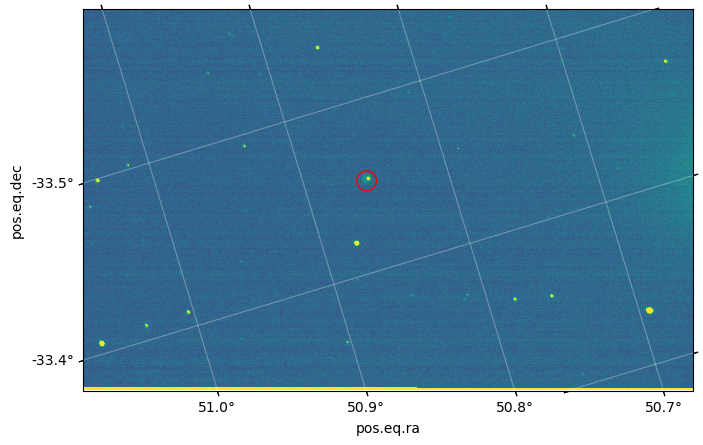

In [15]:
# plot the image with coordinates

# open the image with WCS solution
hdu = fits.open(f)
data = hdu[0].data
hdr = hdu[0].header
wcs = WCS(hdr)

plot_img = data
plot_wcs = wcs

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0], projection = plot_wcs)

# plot image
norm = aviz.ImageNormalize(plot_img,interval=aviz.ZScaleInterval())
s1 = ax1.imshow(plot_img, norm=norm, origin='lower')

# plot target ephem at time t
ax1.scatter(c.ra,c.dec, transform=ax1.get_transform('world'),
           edgecolor = "r", facecolor = "none", s = 200)

# set up coordinate grid
ax1.coords.grid(True, color='white', ls='-', alpha = 0.3)
ax1.coords[0].set_format_unit('degree', decimal = True)
ax1.coords[1].set_format_unit('degree', decimal = True)

plt.tight_layout()

#         plt.savefig(fname,
#                    facecolor='white', transparent=False)

plt.show()

Set MJD-END to 59848.972138 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 59848.972138 from DATE-END'. [astropy.wcs.wcs]


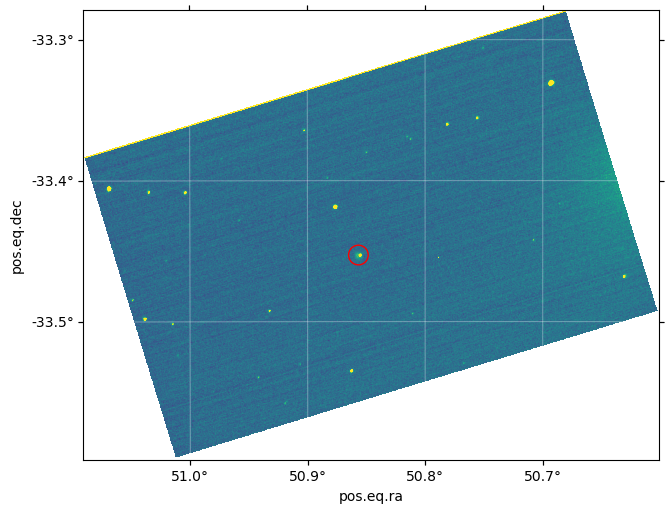

In [16]:
# reproject the image such that North is up and East is left
# https://reproject.readthedocs.io/en/stable/mosaicking.html#reprojecting-and-co-adding-images-into-a-mosaic

# open the image with WCS solution
hdu = fits.open(f)
data = hdu[0].data
hdr = hdu[0].header
wcs = WCS(hdr)

# reproject the image
wcs_in = WCS(hdr)
wcs_out, shape_out = find_optimal_celestial_wcs([hdu[0]])
data_out, footprint = reproject_and_coadd(hdu,
                                       wcs_out, shape_out=shape_out,
                                       reproject_function=reproject_interp)

plot_img = data_out
plot_wcs = wcs_out

fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0,0], projection = plot_wcs)

# plot image
norm = aviz.ImageNormalize(plot_img,interval=aviz.ZScaleInterval())
s1 = ax1.imshow(plot_img, norm=norm)

# plot target ephem at time t
ax1.scatter(c.ra,c.dec, transform=ax1.get_transform('world'),
           edgecolor = "r", facecolor = "none", s = 200)

# set up coordinate grid
ax1.coords.grid(True, color='white', ls='-', alpha = 0.3)
ax1.coords[1].set_format_unit('degree', decimal = True)
ax1.coords[0].set_format_unit('degree', decimal = True)

plt.tight_layout()

#         plt.savefig(fname,
#                    facecolor='white', transparent=False)

plt.show()